In [18]:
import functools
from collections import namedtuple
from pathlib import Path

from copy import deepcopy

import numpy as np

from scipy import signal

from astropy import units as u
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64

if device == 'cuda':
    torch.set_float32_matmul_precision('high')
    
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


# Data Loading

In [20]:
alltensorpaths = list(Path('resampled_tensors').glob('*_2k.pt'))
len(alltensorpaths)

7508

In [21]:
headers = []
wls = []
fluxes = []

for pth in tqdm(alltensorpaths):
    data = torch.load(pth, weights_only=True)
    headers.append(data['header'])
    wls.append(data['wl'])
    fluxes.append(data['flux'])

fluxes = torch.stack(fluxes)

  0%|          | 0/7508 [00:00<?, ?it/s]

In [5]:
assert torch.all(torch.stack(wls)==wls[0])
wl = wls[0]
del wls

In [6]:
teff = torch.tensor([h['PHXTEFF'] for h in headers])
logg = torch.tensor([h['PHXLOGG'] for h in headers])
feh = torch.tensor([h['PHXM_H'] for h in headers])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

make a version of the outputs that are scaled by bb

In [7]:
bbfluxes = []
for hdr in tqdm(headers):
    bb = models.BlackBody(temperature=hdr['PHXTEFF']*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wl << u.angstrom)*(np.pi*u.sr)
    bbfluxes.append(flux.to(u.erg/u.s * u.cm**-3).value)
bbfluxes = torch.from_numpy(np.array(bbfluxes))

bbmean = bbfluxes.mean(axis=-1)

bbsimplescale = fluxes/bbmean[...,None] - 1

def bbsimple_descale(scaled_spec, teff, wl=wl):
    if isinstance(teff, torch.Tensor):
        teff = teff.cpu().detach().numpy() << u.K
    teff = np.atleast_1d(teff)
    bb = models.BlackBody(temperature=teff, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wl[...,None]  << u.angstrom)*(np.pi*u.sr)
    bbmean = flux.mean(axis=0)
    
    scaled_spec = torch.atleast_2d(scaled_spec)
    return (scaled_spec + 1)*bbmean[...,None]

  0%|          | 0/7508 [00:00<?, ?it/s]

# Transformer-based model

In [8]:
# note this assumes all batches have identical encodings, so there is not a batch dimension
class SinusoidalEncoding(nn.Module):
    def __init__(self, n, d_model):
        super().__init__()

        freq = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000) / d_model))
        
        t = torch.arange(n)[..., None]
        encoding_vector = torch.zeros(n, d_model)
        encoding_vector[:, 0::2] = torch.sin(t * freq)
        encoding_vector[:, 1::2] = torch.cos(t * freq)

        self.register_buffer('encoding_vector', encoding_vector)

    def forward(self, x):
        xt = x.tile(self.encoding_vector.shape[-1]).reshape(*self.encoding_vector.shape)
        return xt + self.encoding_vector 

In [9]:
class SpectrumTransformer(nn.Module):
    def __init__(self, 
                 ninfeatures: int, 
                 spec_wls,
                 d_model: int, # dimensionality of the transformer hidden states
                 nhead: int, # number of attention heads, d_model must be divisible by this
                 n_decoder_layers: int, # number of transformer decoder layers
                 dim_feedforward: int, # number of neurons in transformer feedforward layers
                 dropout: float=0, # dropout for transformer
                 nonlinear_cls=nn.GELU, # the class for the activation layers in MLPs 
                 nneurons_feature_embedding=None, # the number of features in the embeddeing, or None for d_model / 2
                 sinusoidal_pe:bool = True, # otherwise trainable embedding
                 use_wl_for_pe: bool = True,
                ):
        super().__init__()
        
        self.register_buffer('spec_wls', torch.Tensor(spec_wls).to(torch.get_default_dtype()))  # also sets the number of pixels
        self.d_model = d_model
        self.use_wl_for_pe = use_wl_for_pe

        if nneurons_feature_embedding is None:
            nneurons_feature_embedding = d_model // 2
        self.feature_embedding = nn.Sequential(
            nn.Linear(ninfeatures, nneurons_feature_embedding),
            nonlinear_cls(),
            nn.Linear(nneurons_feature_embedding, d_model)
        )

        if sinusoidal_pe:
            self.position_encoding = SinusoidalEncoding(self.npixels, d_model)
        else:
            self.position_encoding = nn.Embedding(self.npixels, d_model)


        decoder_layer = nn.TransformerDecoderLayer(d_model,
                                                   nhead, 
                                                   dim_feedforward, 
                                                   dropout,
                                                   nonlinear_cls(),
                                                   batch_first=True,
                                                   norm_first=True)
        last_decoder_norm = nn.LayerNorm(d_model) 
        self.trans_decoder = nn.TransformerDecoder(decoder_layer, n_decoder_layers, last_decoder_norm)

        self.output_layer = nn.Linear(d_model, 1) # each pixel is a scalar
        
    @property
    def npixels(self):
        return self.spec_wls.shape[0]

    def forward(self, x, in_convert=True):
        if in_convert:
            x = self.convert_input(x)
        
        feature_embedded = self.feature_embedding(x)
        if self.use_wl_for_pe:
            pcode_wls = self.position_encoding(self.spec_wls)
        else:
            pcode_wls = self.position_encoding(torch.zeros_like(self.spec_wls))

        # the transformer expects an inner dimension for long token applications (?), so we just make a dimension 1 here
        transformer_features = feature_embedded[:, None, :]
        transformer_pcode = pcode_wls[None, :].expand(transformer_features.shape[0], -1, -1)
        
        transformed = self.trans_decoder(tgt=transformer_pcode, memory=transformer_features, 
                                         tgt_is_causal=False, memory_is_causal=False)

        return self.output_layer(transformed).squeeze(-1)
    
    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype

    def convert_input(self, t):
        return torch.atleast_2d(t).to(self.device, dtype=self.dtype)

model = SpectrumTransformer(
                    ninfeatures=3, 
                    spec_wls=wl, 
                    d_model=256, 
                    nhead=8, 
                    n_decoder_layers=5, 
                    dim_feedforward=1024,
                    dropout=0
).to(dtype=tensor_dtype, device=device)

print(sum(p.numel() for p in model.parameters() if p.requires_grad)*10**-6, 'M parameters')


# do some timing tests and two-batch execution
model.eval()

%time model(torch.Tensor([1,2,3])).detach().cpu().numpy()
%time model(torch.Tensor([1,2,3])).detach().cpu().numpy()

%time model(torch.Tensor([[1,2,3], [4,5,6], [1,2,3], [4,5,6]])).detach().cpu().numpy()

model

5.301505 M parameters
CPU times: user 101 ms, sys: 47.1 ms, total: 148 ms
Wall time: 123 ms
CPU times: user 7.59 ms, sys: 0 ns, total: 7.59 ms
Wall time: 7.59 ms
CPU times: user 28 ms, sys: 4.96 ms, total: 33 ms
Wall time: 33 ms


SpectrumTransformer(
  (feature_embedding): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
  (position_encoding): SinusoidalEncoding()
  (trans_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-4): 5 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affi

In [10]:
split_seed = 42

infeatures_stded = (infeatures - infeatures.mean(0))/infeatures.std(0)

test_data, train_data = random_split(
    TensorDataset(infeatures_stded.to(dtype=tensor_dtype, device=device), 
                  bbsimplescale.to(dtype=tensor_dtype, device=device)), 
    [.3, .7],
    torch.Generator().manual_seed(split_seed)
)

In [11]:
nepochs = 500
batch_size = 256

model = SpectrumTransformer(
                    ninfeatures=3, 
                    spec_wls=wl, 
                    d_model=128, 
                    nhead=4, 
                    n_decoder_layers=3, 
                    dim_feedforward=512,
                    dropout=0.1,
                    use_wl_for_pe=False
).to(dtype=tensor_dtype, device=device)

print(sum(p.numel() for p in model.parameters() if p.requires_grad)*10**-6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-3, 
                              weight_decay=1e-5)
scheduler = None

loss_fcn = nn.MSELoss()

train_losses = []
train_niters = []
test_losses = []
test_niters = []
lrs = []
niters = 0
for _ in (pbar := tqdm(range(nepochs))):
    model.train()

    for data in DataLoader(train_data, batch_size=batch_size, shuffle=True):
        X, Y = data[:2]
        optimizer.zero_grad()
        
        pred = model(X, in_convert=False)
        loss = loss_fcn(pred, Y)
        
        loss.backward()
        optimizer.step()

        niters += X.shape[0]
        
        train_losses.append(loss.item())
        train_niters.append(niters)

    if scheduler is not None:
        scheduler.step()
        lrs.append(scheduler.get_last_lr())
    else:
        lrs.append(optimizer.param_groups[0]['lr'])
    
    model.eval()
    with torch.no_grad():
        n = 0
        cumloss = 0
        for Xt, Yt in DataLoader(test_data, batch_size=batch_size):
            predt = model(Xt)
            cumloss += loss_fcn(Yt, predt).item()*len(predt)
            n += len(predt)
    
        test_losses.append(cumloss/n)
        test_niters.append(niters)
    
    pbar.set_description(f'test loss={test_losses[-1]:.3e}, lr={lrs[-1]:.3e}')

0.802689 M parameters


  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
torch.save(model, f'transformer_2k_{nepochs}e.pt')

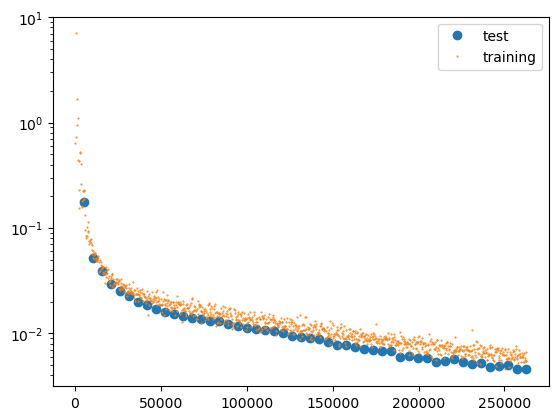

In [13]:
plt.figure()
plt.semilogy(test_niters, test_losses, 'o', c='C0', label='test')
plt.semilogy(train_niters, train_losses, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
# if lrs:
#     plt.twinx()
#     plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
#     plt.ylabel('learning rate', color='C2')


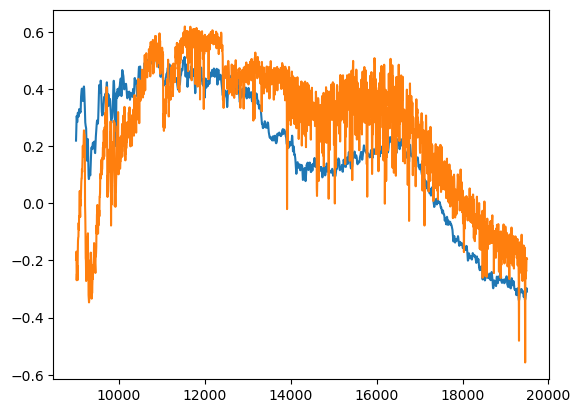

In [14]:
plt.plot(wl, predt[-1].detach().cpu())
plt.plot(wl, Yt[-1].detach().cpu())